In [1]:
import networkx as nx

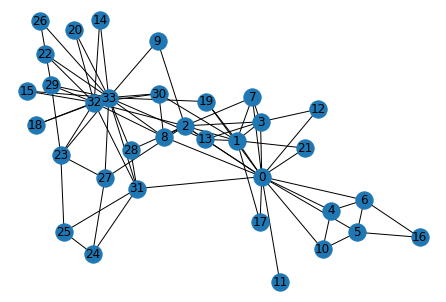

In [2]:
# Create a graph and visualize it
G = nx.karate_club_graph()

import matplotlib.pyplot as plt
nx.draw(G,with_labels=True)

In [3]:
# DG is directed version of G. Replaces each edge {i,j} by (i,j) and (j,i)
DG = nx.DiGraph(G)

# Pick some arbitrary arc costs
c = { (i,j) : i*j for (i,j) in DG.edges }

r = 0  # tree root, arbitrarily chosen

In [4]:
import gurobipy as gp
from gurobipy import GRB

In [5]:
# Create model object
m = gp.Model()

# Create x and f variables for each edge
x = m.addVars( DG.edges, vtype=GRB.BINARY )
f = m.addVars( DG.edges, vtype=GRB.CONTINUOUS )

# Objective function: minimize cost of selected edges
m.setObjective( gp.quicksum( c[i,j] * x[i,j] for i,j in DG.edges ), GRB.MINIMIZE )

# Constraints: each node (besides r) should have one incoming arc
m.addConstrs( gp.quicksum( x[j,i] for j in DG.neighbors(i) ) == 1 for i in G.nodes if i != r )
m.addConstr( gp.quicksum( x[j,r] for j in DG.neighbors(r) ) == 0 )

# Constraints: each node (besides r) should consume one unit of flow
m.addConstrs( gp.quicksum( f[j,i] - f[i,j] for j in DG.neighbors(i) ) == 1 for i in G.nodes if i != r )

# Constraints: flow can only cross built edges
m.addConstrs( f[i,j] <= ( G.number_of_nodes() - 1 ) * x[i,j] for i,j in DG.edges )

# Solve
m.optimize()

Academic license - for non-commercial use only - expires 2021-07-26
Using license file C:\Users\Austin\gurobi.lic
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 223 rows, 312 columns and 748 nonzeros
Model fingerprint: 0xaf0dc4e0
Variable types: 156 continuous, 156 integer (156 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [2e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 73 rows and 93 columns
Presolve time: 0.04s
Presolved: 150 rows, 219 columns, 550 nonzeros
Variable types: 123 continuous, 96 integer (96 binary)
Found heuristic solution: objective 6631.0000000

Root relaxation: infeasible, 14 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible  

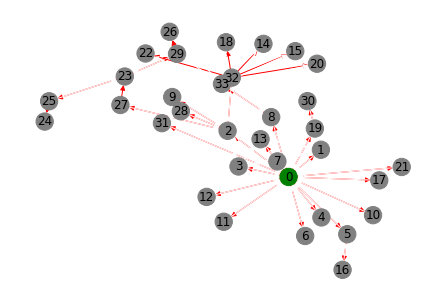

In [6]:
# Visualize the solution
tree_edges = [ (i,j) for i,j in DG.edges if x[i,j].x > 0.5 ]

edge_colors = [ "red" if i in tree_edges else "white" for i in DG.edges ]
node_colors = [ "green" if i == r else "gray" for i in DG.nodes ]

nx.draw( DG, with_labels=True, edge_color=edge_colors, node_color=node_colors )